In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
import PIL
import glob
from custom_gen import DataGenerator
from vae import VAE, Sampling

In [2]:
params = {'dim': (128,128,1),
          'batch_size': 32,
          'n_classes': 1,
          'n_channels': 1,
          'shuffle': True}
upperG = glob.glob('by_class/47/*.png')
input_data = DataGenerator(upperG,[0]*len(upperG),**params)

In [3]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(128, 128, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
______________________________________________________________________________________

In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(32 * 32 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((32, 32, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 65536)             196608    
_________________________________________________________________
reshape (Reshape)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 64, 64, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 128, 128, 32)      18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 128, 128, 1)       289       
Total params: 252,289
Trainable params: 252,289
Non-trainable params: 0
_____________________________________________________

In [8]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
vae.fit(input_data, epochs=10)

Epoch 1/10
173/173 [==============================] - 130s 751ms/step - loss: 2854.3685 - reconstruction_loss: 1968.9312 - kl_loss: 235.2742
Epoch 2/10
173/173 [==============================] - 132s 761ms/step - loss: 1895.0791 - reconstruction_loss: 1838.7820 - kl_loss: 19.7961
Epoch 3/10
173/173 [==============================] - 132s 765ms/step - loss: 1789.3099 - reconstruction_loss: 1760.7793 - kl_loss: 16.2762
Epoch 4/10
173/173 [==============================] - 131s 757ms/step - loss: 1759.6779 - reconstruction_loss: 1745.6582 - kl_loss: 12.9844
Epoch 5/10
173/173 [==============================] - 131s 760ms/step - loss: 1736.0084 - reconstruction_loss: 1718.3800 - kl_loss: 12.2478
Epoch 6/10
173/173 [==============================] - 132s 763ms/step - loss: 1711.8949 - reconstruction_loss: 1708.8389 - kl_loss: 11.2376
Epoch 7/10
173/173 [==============================] - 133s 766ms/step - loss: 1714.7073 - reconstruction_loss: 1698.3295 - kl_loss: 10.6382
Epoch 8/10
173/173 

In [ ]:
def plot_label_clusters(vae, data):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


plot_label_clusters(vae, x_train)

In [12]:
test_img = np.array(PIL.Image.open('by_class/47/hsf_7_00224.png').convert('L')).reshape((128,128,1)).astype('float32')/255

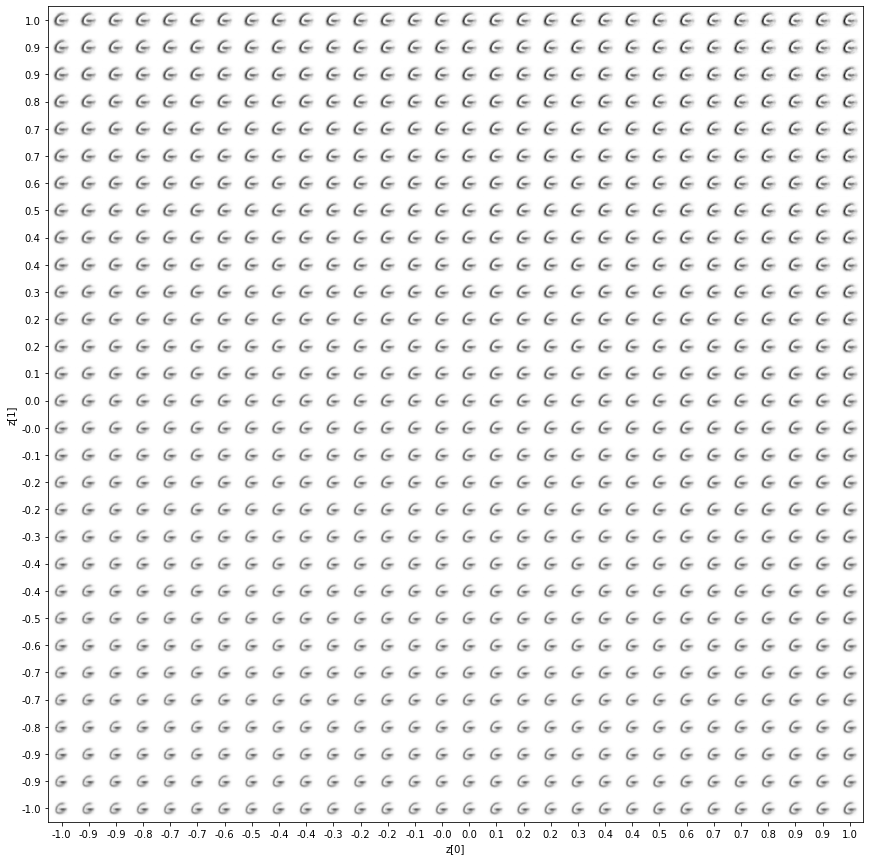

In [19]:
def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 128
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)